# Notebook de Regress√£o ‚Äî Previs√£o de Custos de Nuvem  
## Projeto: Trilha A ‚Äì Dados & IA (2¬™ parte: Modelo de ML)

Este notebook documenta, passo a passo, a segunda parte do projeto: a constru√ß√£o de um **pipeline de Machine Learning** para **prever custos de nuvem** a partir de dados p√∫blicos (ex.: AWS, Azure, GCP).  
Ele complementa a primeira parte (ingest√£o e processamento) e entrega:
- C√≥digo-fonte comentado
- Notebook com explica√ß√£o do pipeline
- Gr√°ficos e m√©tricas do modelo
- Gera√ß√£o de arquivo `.csv` com previs√µes e erros


## 1) Bibliotecas e organiza√ß√£o do ambiente

Aqui importamos as depend√™ncias para:
- manipula√ß√£o de dados (`pandas`, `numpy`),
- pr√©-processamento (one-hot encoding, `ColumnTransformer`),
- modelagem (regressor linear b√°sico e op√ß√£o de XGBoost),
- avalia√ß√£o (MAE, RMSE, R¬≤),
- e separa√ß√£o treino/teste.


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


## 2) Carregar os dados tratados

Carregamos o `.csv` **j√° processado** na etapa de ingest√£o/limpeza. Em seguida, fazemos uma checagem r√°pida do *head* para validar o schema e o conte√∫do.


In [43]:
# Carregar o CSV tratado
df = pd.read_csv("cloud_pricing_processed.csv")

# Visualizar rapidamente
df.head()


name series           family location         region  vCpus  \
0   c4-highcpu-16     c4  General-purpose   africa  africa-south1   16.0   
1  c4-highcpu-192     c4  General-purpose   africa  africa-south1  192.0   
2    c4-highcpu-2     c4  General-purpose   africa  africa-south1    2.0   
3   c4-highcpu-24     c4  General-purpose   africa  africa-south1   24.0   
4   c4-highcpu-32     c4  General-purpose   africa  africa-south1   32.0   

   memoryGB       hour  hourSpot        month    monthSpot  \
0      32.0   0.889984  0.355985   649.688413   259.869254   
1     384.0  10.679810  4.271823  7796.260961  3118.431053   
2       4.0   0.111248  0.044498    81.211052    32.483657   
3      48.0   1.334976  0.533978   974.532620   389.803882   
4      64.0   1.779968  0.711971  1299.376827   519.738509   

   cost_per_vcpu_hour  cost_per_gb_hour  
0            0.055624          0.027812  
1            0.055624          0.027812  
2            0.055624          0.027812  
3            0.055624          0.027812  
4            0.055624          0.027812

## 3) Definir **target** e **features**

Nesta etapa:
- Escolhemos a vari√°vel **alvo** (custo/pre√ßo a ser previsto). Exemplos comuns: `costUSD`, `price`, `hourlyCost`, `monthlyCost`.
- Selecionamos **features** relevantes. Ex.: capacidade de CPU e mem√≥ria, fam√≠lia/tipo de inst√¢ncia, regi√£o/zona.


In [44]:
# Target (vari√°vel que queremos prever)
y = df["cost_per_vcpu_hour"]

# Features preditoras
X = df[["vCpus", "memoryGB", "family", "region", "location"]]


## 4) Pr√©-processamento com `ColumnTransformer`

Separa√ß√£o entre:
- **Num√©ricas** (passam direto ‚Äî `passthrough`)
- **Categ√≥ricas** (codificadas via `OneHotEncoder`)

Usamos `handle_unknown="ignore"` no encoder para lidar com categorias novas que possam aparecer em dados futuros (evita erro na infer√™ncia).

In [45]:
# Separar colunas num√©ricas e categ√≥ricas
num_features = ["vCpus", "memoryGB"]
cat_features = ["family", "region", "location"]

# Criar transformador para one-hot nas categ√≥ricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


## 5) Constru√ß√£o do **pipeline** do modelo

O pipeline encadeia o **pr√©-processamento** e o **regressor**.  
Come√ßamos com `LinearRegression` como **baseline** por ser r√°pido e servir de refer√™ncia.  


=== Regress√£o Linear ===
MAE: 0.01683
RMSE: 0.03553
R¬≤: 0.60980


/tmp/ipykernel_34664/3735824171.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_coef_df, x="coef", y="feature", palette="viridis", ax=axes[1])


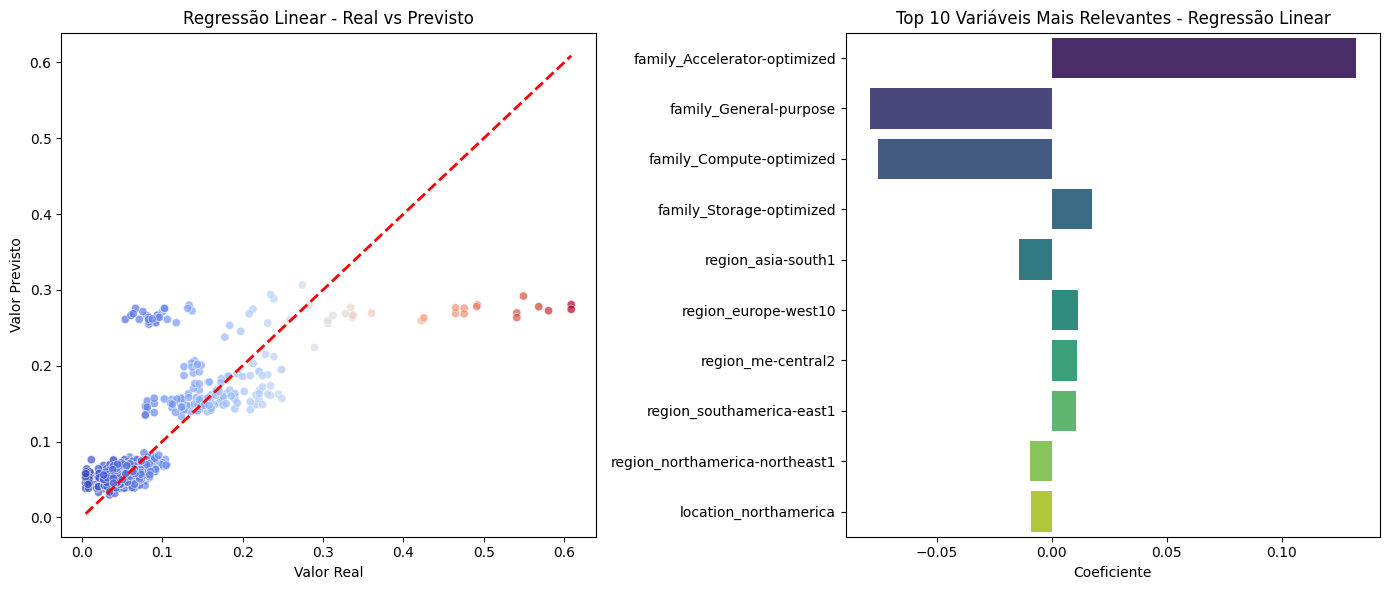

In [62]:
# ============================
# Regress√£o Linear com Pipeline
# ============================
lin_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

print("=== Regress√£o Linear ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lin):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin)):.5f}")
print(f"R¬≤: {r2_score(y_test, y_pred_lin):.5f}")

# ===============================
# Regress√£o Linear - Compara√ß√£o
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real vs Previsto
sns.scatterplot(x=y_test, y=y_pred_lin, hue=y_test, palette="coolwarm", alpha=0.7, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[0].set_title("Regress√£o Linear - Real vs Previsto")
axes[0].set_xlabel("Valor Real")
axes[0].set_ylabel("Valor Previsto")
axes[0].legend([],[], frameon=False)

# Import√¢ncia das vari√°veis
top_coef_df = coef_df.head(10)
sns.barplot(data=top_coef_df, x="coef", y="feature", palette="viridis", ax=axes[1])
axes[1].set_title("Top 10 Vari√°veis Mais Relevantes - Regress√£o Linear")
axes[1].set_xlabel("Coeficiente")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


=== XGBoost ===
MAE: 0.00541
RMSE: 0.00947
R¬≤: 0.97230


/tmp/ipykernel_34664/2819547070.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_xgb_df, x="importance", y="feature", palette="mako", ax=axes[1])


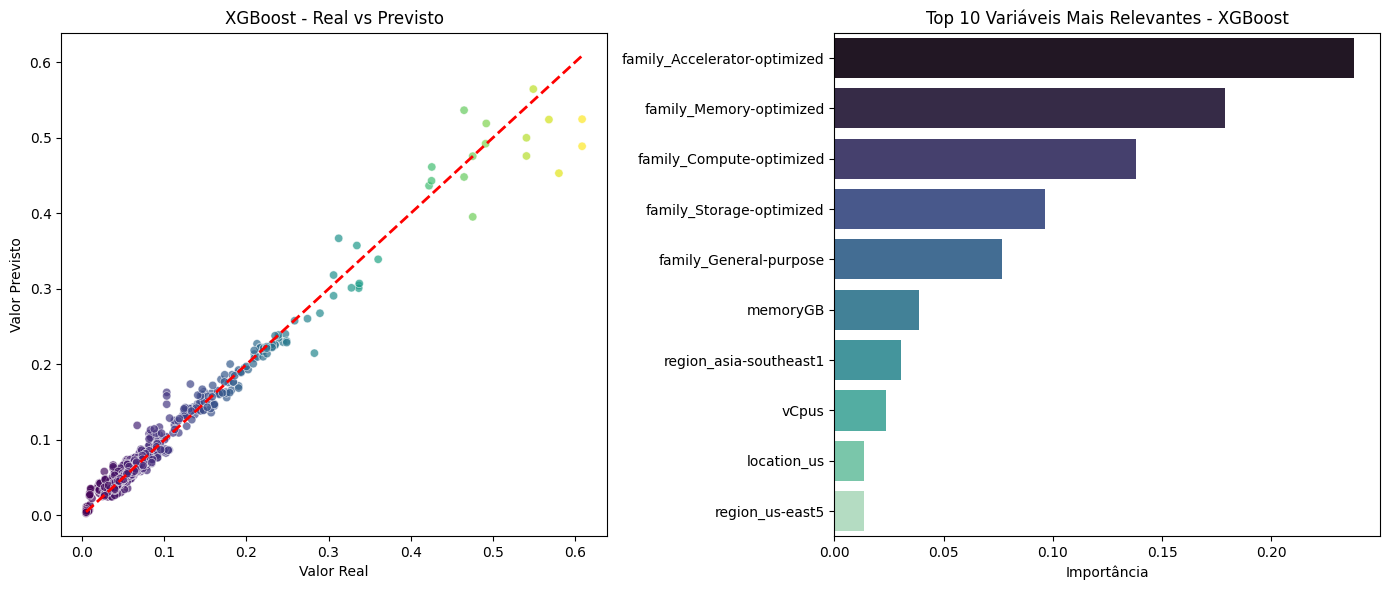

In [61]:
# ============================
# XGBoost
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_transformed, y_train)
y_pred_xgb = xgb_model.predict(X_test_transformed)

print("\n=== XGBoost ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.5f}")
print(f"R¬≤: {r2_score(y_test, y_pred_xgb):.5f}")

# ===============================
# XGBoost - Compara√ß√£o
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real vs Previsto
sns.scatterplot(x=y_test, y=y_pred, hue=y_test, palette="viridis", alpha=0.7, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[0].set_title("XGBoost - Real vs Previsto")
axes[0].set_xlabel("Valor Real")
axes[0].set_ylabel("Valor Previsto")
axes[0].legend([],[], frameon=False)  # remove legenda polu√≠da

# Import√¢ncia das vari√°veis
top_xgb_df = xgb_df.head(10)
sns.barplot(data=top_xgb_df, x="importance", y="feature", palette="mako", ax=axes[1])
axes[1].set_title("Top 10 Vari√°veis Mais Relevantes - XGBoost")
axes[1].set_xlabel("Import√¢ncia")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

## 6) Treino, Valida√ß√£o e Avalia√ß√£o dos Modelos

Ap√≥s a prepara√ß√£o dos dados, o conjunto foi dividido em **treino (80%)** e **teste (20%)**.  
Foram testados dois modelos de regress√£o:

- **Regress√£o Linear** ‚Üí modelo simples e interpret√°vel, usado como *baseline*.  
- **XGBoost Regressor** ‚Üí modelo de *gradient boosting*, mais robusto e capaz de capturar rela√ß√µes n√£o lineares.

### M√©tricas de Avalia√ß√£o
As m√©tricas utilizadas foram:

- **MAE** (*Mean Absolute Error*) ‚Üí erro absoluto m√©dio; mede o erro m√©dio em unidades do alvo.  
- **RMSE** (*Root Mean Squared Error*) ‚Üí raiz do erro quadr√°tico m√©dio; penaliza mais fortemente erros grandes.  
- **R¬≤** (*Coeficiente de Determina√ß√£o*) ‚Üí propor√ß√£o da vari√¢ncia explicada; quanto mais pr√≥ximo de 1, melhor o ajuste.  

**Resultados obtidos:**

| Modelo              | MAE     | RMSE    | R¬≤     |
|----------------------|---------|---------|--------|
| Regress√£o Linear     | 0.01683 | 0.03553 | 0.6098 |
| XGBoost Regressor    | 0.00541 | 0.00947 | 0.9723 |

‚û°Ô∏è **Conclus√£o**: O XGBoost superou amplamente o baseline, explicando **97% da vari√¢ncia** dos custos e apresentando erros m√©dios quase **3 vezes menores**.

### Visualiza√ß√µes
Foram produzidas as seguintes visualiza√ß√µes para apoiar a an√°lise dos modelos:

- **Dispers√£o Real vs. Previsto** ‚Üí quanto mais pr√≥ximos os pontos estiverem da linha vermelha (45¬∞), melhor a previs√£o.  
- **Res√≠duos vs. Valor Real** ‚Üí erros centrados em 0 indicam aus√™ncia de vi√©s sistem√°tico.  
- **Import√¢ncia das Vari√°veis** ‚Üí destaca os atributos (fam√≠lia de inst√¢ncia, vCPUs, mem√≥ria, regi√£o, etc.) que mais impactam no custo.

---

## 7) Interpretabilidade: Import√¢ncia de Vari√°veis

Para compreender como cada atributo influencia os modelos, extra√≠mos a import√¢ncia das vari√°veis:

- **Regress√£o Linear**:  
  A contribui√ß√£o √© medida pelos **coeficientes**.  
  - Valores positivos indicam aumento no custo conforme a vari√°vel cresce.  
  - Valores negativos indicam efeito de redu√ß√£o.  
  - Como os dados categ√≥ricos foram transformados via *One-Hot Encoding*, cada categoria tem seu pr√≥prio peso no modelo.  

- **XGBoost**:  
  A import√¢ncia √© derivada da frequ√™ncia e impacto das vari√°veis nas divis√µes das √°rvores.  
  - Valores maiores indicam que a feature contribui mais para reduzir o erro do modelo.  
  - Todas as import√¢ncias s√£o positivas, mas n√£o representam diretamente o tamanho do impacto, apenas a relev√¢ncia relativa.  

üìä **Top 10 vari√°veis mais influentes** foram destacadas nos gr√°ficos, para focar nos fatores realmente determinantes no custo de nuvem.
